<a href="https://colab.research.google.com/github/saimaayub/DS-project/blob/main/FPR_CODING.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install pandas

#Importing required libraries

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error, r2_score
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
import statsmodels.api as sm
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense
from sklearn.model_selection import train_test_split
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose

#**EDA(Exploratory Data Analysis):**


1.   EDA includes making a dataset that contains daily data for both energy consumption and weather variables.
2.   Plotting these weather variables against energy consumption to observe their relationships, correlation.
3. Plotting a heatmap to observe correlations of weather variables with energy consumption.

#Merging fragments of whole data converted into daily data in one dataframe.

In [3]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Defining csv file paths in google drive
csv_file_paths = [
    '/content/drive/MyDrive/50AvgDailyData.csv',
    '/content/drive/MyDrive/51AvgDailyData.csv',
    '/content/drive/MyDrive/101AvgDailyData.csv',
    '/content/drive/MyDrive/131AvgDailyData.csv'
]

# Loading each csv file into a DataFrame to store them in a list
dataframes = []
for file_path in csv_file_paths:
    df = pd.read_csv(file_path)
    dataframes.append(df)

# To make a single dataframe concatenate all DataFrames.
merged_df1 = pd.concat(dataframes, ignore_index=True)

Mounted at /content/drive


In [4]:
merged_df1.head(3000)

,level_0,index,Date,Average KWH per Day
0,0.0,0,2011-11-23,4.327500
1,1.0,1,2011-11-24,6.111750
2,2.0,2,2011-11-25,6.886333
3,3.0,3,2011-11-26,7.709500
4,4.0,4,2011-11-27,7.813500
...,...,...,...,...
2995,NaN,525,2013-05-09,9.182081
2996,NaN,526,2013-05-10,9.139073
2997,NaN,527,2013-05-11,9.819537
2998,NaN,528,2013-05-12,10.381565


In [5]:
merged_df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3291 entries, 0 to 3290
Data columns (total 4 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   level_0              829 non-null    float64
 1   index                3291 non-null   int64  
 2   Date                 3291 non-null   object 
 3   Average KWH per Day  3291 non-null   float64
dtypes: float64(2), int64(1), object(1)
memory usage: 103.0+ KB


#Merge data again to avoid multiple entries for same date by averaging energy consumption values for a single date.  

In [6]:
# Convert to DateTime format
merged_df1['Date'] = pd.to_datetime(merged_df1['Date'])

# To merge data by Date calculating the mean of 'KWH/hh (per half hour)'
daily_data = merged_df1.groupby(merged_df1['Date'].dt.date)['Average KWH per Day'].mean().reset_index()

# To avoid the errors renaming the columns for clarity
daily_data.columns = ['Date', 'Average KWH']

# Verify the daily_data DataFrame
print(f"Daily data shape: {daily_data.shape}")
print(daily_data.head())

# Save the daily data obtained as a csv file in google drive
daily_csv_file_path = '/content/drive/MyDrive/LCL-Final-Average-Merged-DailyData.csv'
daily_data.to_csv(daily_csv_file_path, index=False)

print(f"Daily data saved to: {daily_csv_file_path}")

Daily data shape: (829, 2)
         Date  Average KWH
0  2011-11-23     5.878750
1  2011-11-24     7.555042
2  2011-11-25     8.494609
3  2011-11-26     9.207879
4  2011-11-27     9.592493
Daily data saved to: /content/drive/MyDrive/LCL-Final-Average-Merged-DailyData.csv


In [7]:
print("Energy data date range:", merged_df1['Date'].min(), merged_df1['Date'].max())
print("Energy data consumption range:", merged_df1['Average KWH per Day'].min(), merged_df1['Average KWH per Day'].max())

Energy data date range: 2011-11-23 00:00:00 2014-02-28 00:00:00
Energy data consumption range: 0.3569800415691672 17.056263163157894


#Line plot of daily energy consumption.

---



---



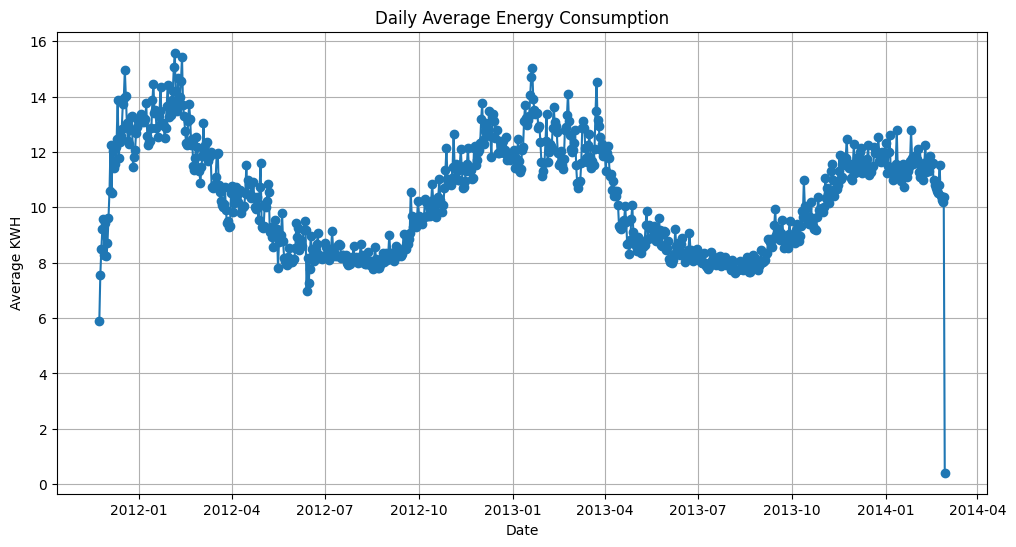

In [8]:
#plotting the data
plt.figure(figsize=(12, 6))
plt.plot(daily_data['Date'], daily_data['Average KWH'], marker='o', linestyle='-')
plt.title('Daily Average Energy Consumption')
plt.xlabel('Date')
plt.ylabel('Average KWH')
plt.grid(True)
plt.show()

In [9]:
print(daily_data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 829 entries, 0 to 828
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Date         829 non-null    object 
 1   Average KWH  829 non-null    float64
dtypes: float64(1), object(1)
memory usage: 13.1+ KB
None


#Now calling daily weather data from drive.

In [10]:
file_path = '/content/drive/My Drive/weather-data.csv'
weatherdf = pd.read_csv(file_path)
print(weatherdf.head(3))

         time  weather_code (wmo code)  temperature_2m_max (°C)  \
0  01/11/2011                       51                     15.0   
1  02/11/2011                       51                     14.2   
2  03/11/2011                       53                     15.6   

   temperature_2m_min (°C)  temperature_2m_mean (°C)  \
0                      8.9                      13.1   
1                      8.4                      11.4   
2                     12.9                      14.6   

   apparent_temperature_max (°C)  apparent_temperature_min (°C)  \
0                           13.2                            7.1   
1                           12.1                            6.0   
2                           13.7                           11.9   

   apparent_temperature_mean (°C) sunrise (iso8601)  sunset (iso8601)  \
0                            11.3  2011-11-01T07:53  2011-11-01T17:34   
1                             8.6  2011-11-02T07:55  2011-11-02T17:33   
2                 

In [11]:
# Converting the time column to datetime format.
weatherdf['Date'] = pd.to_datetime(weatherdf['time'], dayfirst=True)
weatherdf.head()

,time,weather_code (wmo code),temperature_2m_max (°C),temperature_2m_min (°C),temperature_2m_mean (°C),apparent_temperature_max (°C),apparent_temperature_min (°C),apparent_temperature_mean (°C),sunrise (iso8601),sunset (iso8601),daylight_duration (s),sunshine_duration (s),precipitation_sum (mm),rain_sum (mm),precipitation_hours (h),wind_speed_10m_max (km/h),wind_direction_10m_dominant (°),Date
0,01/11/2011,51,15.0,8.9,13.1,13.2,7.1,11.3,2011-11-01T07:53,2011-11-01T17:34,34876.89,23635.93,0.9,0.9,5,18.8,205,2011-11-01
1,02/11/2011,51,14.2,8.4,11.4,12.1,6.0,8.6,2011-11-02T07:55,2011-11-02T17:33,34662.17,24176.65,1.6,1.6,5,23.4,142,2011-11-02
2,03/11/2011,53,15.6,12.9,14.6,13.7,11.9,12.8,2011-11-03T07:57,2011-11-03T17:31,34448.32,899.05,4.1,4.1,15,25.8,163,2011-11-03
3,04/11/2011,61,14.9,11.1,12.7,12.8,10.2,11.4,2011-11-04T07:59,2011-11-04T17:29,34235.54,10425.34,12.8,12.8,16,19.6,177,2011-11-04
4,05/11/2011,51,13.9,8.6,11.4,12.0,7.5,9.7,2011-11-05T08:00,2011-11-05T17:27,34024.06,6934.98,0.4,0.4,4,19.0,355,2011-11-05


In [12]:
#Checking for missing values

missing_values_per_column = weatherdf.isnull().sum()
print(missing_values_per_column)

time                               0
weather_code (wmo code)            0
temperature_2m_max (°C)            0
temperature_2m_min (°C)            0
temperature_2m_mean (°C)           0
apparent_temperature_max (°C)      0
apparent_temperature_min (°C)      0
apparent_temperature_mean (°C)     0
sunrise (iso8601)                  0
sunset (iso8601)                   0
daylight_duration (s)              0
sunshine_duration (s)              0
precipitation_sum (mm)             0
rain_sum (mm)                      0
precipitation_hours (h)            0
wind_speed_10m_max (km/h)          0
wind_direction_10m_dominant (°)    0
Date                               0
dtype: int64


In [13]:
# Convert 'Date' columns to datetime in both DataFrames
daily_data['Date'] = pd.to_datetime(daily_data['Date'])
weatherdf['Date'] = pd.to_datetime(weatherdf['Date'])

# Now merge the DataFrames
merged_df = pd.merge(daily_data, weatherdf, on='Date')
print(merged_df.head())
merged_df = pd.merge(daily_data, weatherdf, on='Date')
print(merged_df.head(2))

        Date  Average KWH        time  weather_code (wmo code)  \
0 2011-11-23     5.878750  23/11/2011                        3   
1 2011-11-24     7.555042  24/11/2011                        3   
2 2011-11-25     8.494609  25/11/2011                        3   
3 2011-11-26     9.207879  26/11/2011                        2   
4 2011-11-27     9.592493  27/11/2011                        3   

   temperature_2m_max (°C)  temperature_2m_min (°C)  temperature_2m_mean (°C)  \
0                     10.2                      2.9                       7.4   
1                     12.1                      7.7                       9.6   
2                     12.6                      6.4                      10.5   
3                     11.9                      6.2                       8.9   
4                     13.1                      3.0                       9.8   

   apparent_temperature_max (°C)  apparent_temperature_min (°C)  \
0                            7.5                 

In [14]:
print("Weather data date range:", weatherdf['Date'].min(), weatherdf['Date'].max())

Weather data date range: 2011-11-01 00:00:00 2014-02-28 00:00:00


#Plot of energy consumption and temperature.


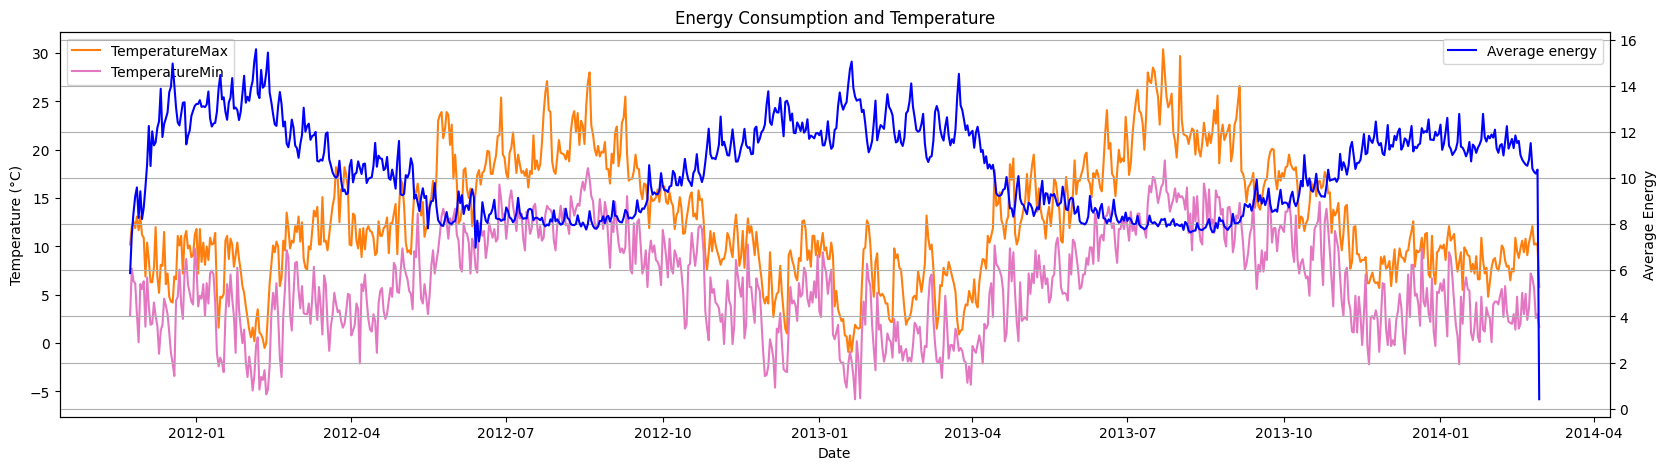

In [15]:
# Plotting
fig, ax1 = plt.subplots(figsize=(20, 5))

# Plot temperature data
ax1.plot(merged_df['Date'], merged_df['temperature_2m_max (°C)'], color='tab:orange', label='TemperatureMax')
ax1.plot(merged_df['Date'], merged_df['temperature_2m_min (°C)'], color='tab:pink', label='TemperatureMin')
ax1.set_xlabel('Date')
ax1.set_ylabel('Temperature (°C)')
ax1.legend(loc='upper left')
# Create a second y-axis for energy consumption
ax2 = ax1.twinx()
ax2.plot(merged_df['Date'], merged_df['Average KWH'], color='blue', label='Average energy')
ax2.set_ylabel('Average Energy')
ax2.legend(loc='upper right')
# Title and grid
plt.title('Energy Consumption and Temperature')
plt.grid()

plt.show()

**Interpretation**
The graph above shows that energy consumption and temperature have a strong negative correlation.

*   Rather than plotting many graphs to check correlation among different
variables and energy consumption we move to correlation matrix to observe all correlations simultaneously*


In [16]:
# Select only numeric columns as correlation requires data to be numeric.
numeric_cols = ['Average KWH', 'temperature_2m_max (°C)', 'temperature_2m_min (°C)',
                'temperature_2m_mean (°C)', 'apparent_temperature_max (°C)',
                'apparent_temperature_min (°C)', 'apparent_temperature_mean (°C)',
                'daylight_duration (s)', 'sunshine_duration (s)', 'precipitation_sum (mm)',
                'rain_sum (mm)', 'precipitation_hours (h)', 'wind_speed_10m_max (km/h)',
                'wind_direction_10m_dominant (°)']
numeric_cols = [col for col in numeric_cols if col in merged_df.columns]

# Calculating correlation matrix
cor_matrix = merged_df[numeric_cols].corr()
cor_matrix

,Average KWH,temperature_2m_max (°C),temperature_2m_min (°C),temperature_2m_mean (°C),apparent_temperature_max (°C),apparent_temperature_min (°C),apparent_temperature_mean (°C),daylight_duration (s),sunshine_duration (s),precipitation_sum (mm),rain_sum (mm),precipitation_hours (h),wind_speed_10m_max (km/h),wind_direction_10m_dominant (°)
Average KWH,1.000000,-0.859852,-0.784708,-0.850199,-0.844128,-0.806787,-0.846644,-0.768874,-0.529197,0.024979,-0.003920,0.018915,0.192651,-0.011422
temperature_2m_max (°C),-0.859852,1.000000,0.893754,0.976832,0.986691,0.916056,0.974823,0.709260,0.519077,-0.021886,0.005665,-0.060380,-0.175285,0.046225
temperature_2m_min (°C),-0.784708,0.893754,1.000000,0.962064,0.880056,0.983630,0.943438,0.605903,0.295276,0.090157,0.111975,0.091817,-0.034668,0.054723
temperature_2m_mean (°C),-0.850199,0.976832,0.962064,1.000000,0.962703,0.967904,0.988504,0.675845,0.423053,0.031448,0.057314,0.011007,-0.105292,0.056703
apparent_temperature_max (°C),-0.844128,0.986691,0.880056,0.962703,1.000000,0.917766,0.981422,0.694272,0.483703,-0.017377,0.007908,-0.058084,-0.284309,0.030206
apparent_temperature_min (°C),-0.806787,0.916056,0.983630,0.967904,0.917766,1.000000,0.971236,0.625328,0.316476,0.053058,0.075549,0.048172,-0.162718,0.039176
apparent_temperature_mean (°C),-0.846644,0.974823,0.943438,0.988504,0.981422,0.971236,1.000000,0.674809,0.412379,0.009284,0.033560,-0.014316,-0.233155,0.041022
daylight_duration (s),-0.768874,0.709260,0.605903,0.675845,0.694272,0.625328,0.674809,1.000000,0.570088,-0.001417,0.010596,0.028930,-0.224049,-0.118022
sunshine_duration (s),-0.529197,0.519077,0.295276,0.423053,0.483703,0.316476,0.412379,0.570088,1.000000,-0.269423,-0.254392,-0.308494,-0.194610,-0.030874
precipitation_sum (mm),0.024979,-0.021886,0.090157,0.031448,-0.017377,0.053058,0.009284,-0.001417,-0.269423,1.000000,0.992531,0.830122,0.350287,-0.056068


#Making heatmap to present correlation matrix

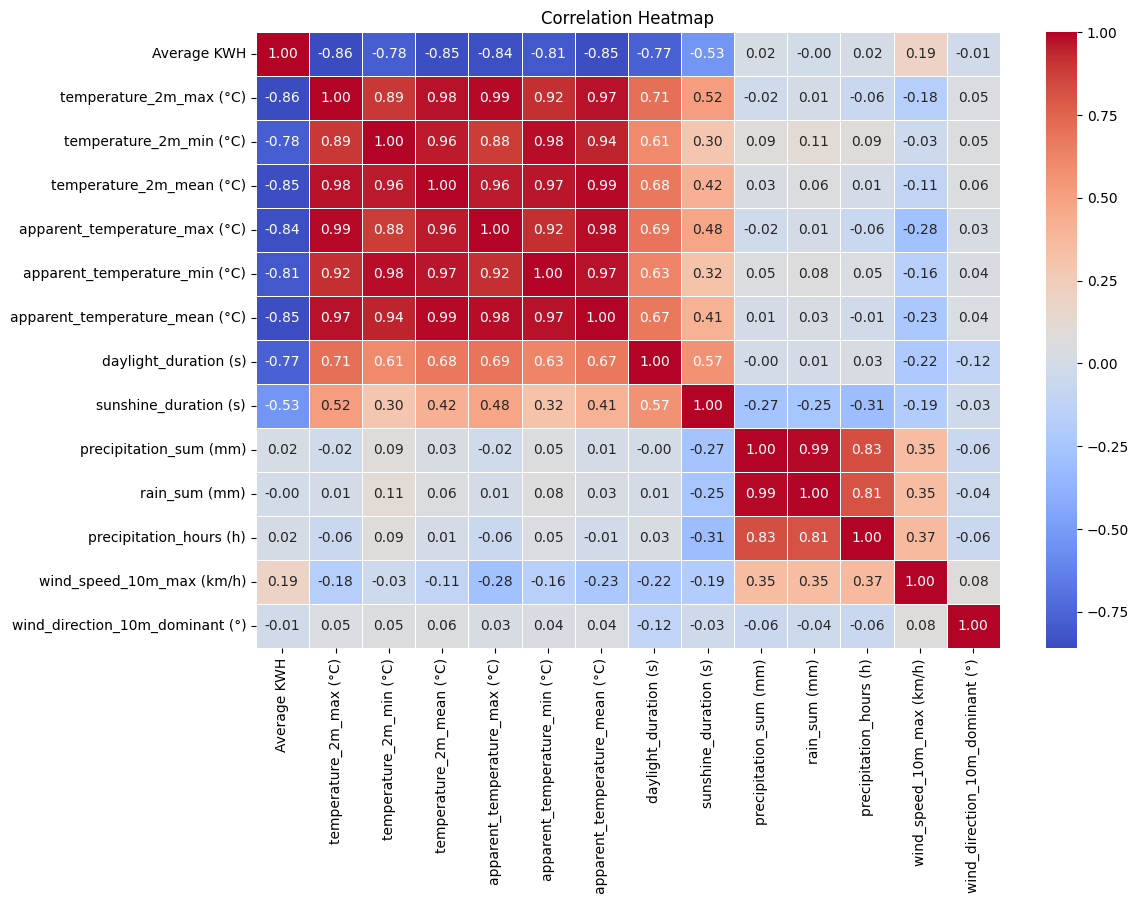

In [17]:

plt.figure(figsize=(12, 8))

# Drawing the heatmap with the obtained correlation matrix
sns.heatmap(cor_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)

# Adding labels to graph
plt.title('Correlation Heatmap')
plt.show()

**Interpretation:**

It can be observed that various weather variables and average energy consumption have different correlations. Temperature variables show a strong negative correlation (-0.86, -0.78, -0.85, -0.84) with energy consumption. Also, daylight duration has a strong negative correlation (-0.77) with energy consumption. So, with longer daylight durations and higher temperatures, a decrease in energy consumption is observed. On the other hand, wind speed has a weak positive correlation (0.19) with energy consumption.

In [18]:
#scaling
scaler = MinMaxScaler()
weather = scaler.fit_transform(merged_df[['temperature_2m_mean (°C)']])

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` ex

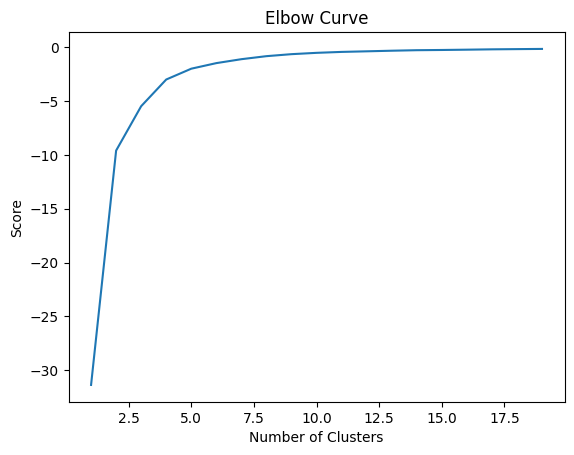

In [ ]:
# optimum K
Nc = range(1, 20)
kmeans = [KMeans(n_clusters=i) for i in Nc]
kmeans
score = [kmeans[i].fit(weather).score(weather) for i in range(len(kmeans))]
score
plt.plot(Nc,score)
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.title('Elbow Curve')
plt.show()

**Interpretation:**
score:the sum of squared distances from each point to its assigned cluster center.
from elbow curve we can observe that optimal number of clusters is 5 as curve becomes flat after 5.

In [ ]:
kmeans = KMeans(n_clusters=5, max_iter=600, algorithm = 'auto')
kmeans.fit(weather)
merged_df['weather_cluster'] = kmeans.labels_

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1420: FutureWarning: algorithm='auto' is deprecated, it will be removed in 1.3. Using 'lloyd' instead.
  warnings.warn(


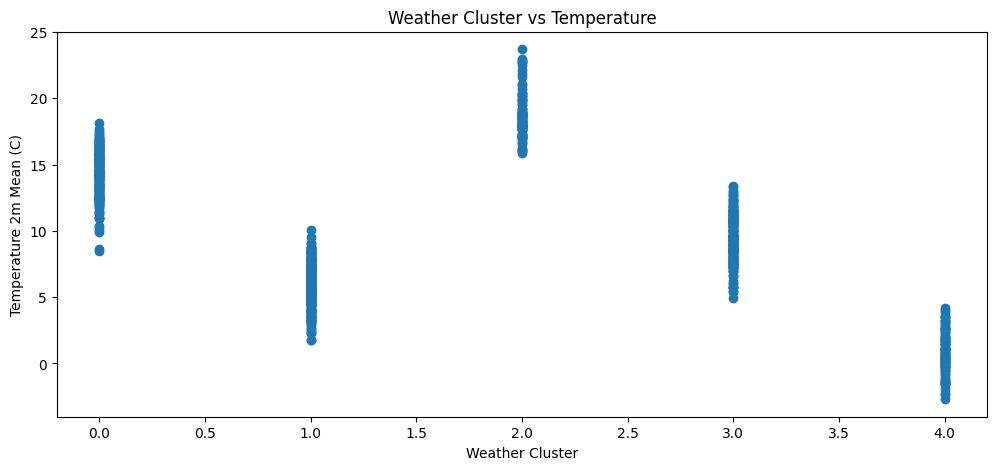

In [ ]:
# Renaming the column to avoid errors
merged_df.rename(columns={'temperature_2m_mean (°C)': 'temperature_2m_mean_C'}, inplace=True)

# Now using the new column name for plotting
# Cluster Relationships with weather variables
plt.figure(figsize=(12,5))
plt.scatter(merged_df['weather_cluster'], merged_df['temperature_2m_mean_C'])
plt.xlabel('Weather Cluster')
plt.ylabel('Temperature 2m Mean (C)')
plt.title('Weather Cluster vs Temperature')
plt.show()

**Interpretation:**

Five clusters have been formed

weather cluster = 3 = low temperature values

weather cluster = 2 = high temperature values

In [ ]:
merged_df.head(2)

,Date,Average KWH,time,weather_code (wmo code),temperature_2m_max (°C),temperature_2m_min (°C),temperature_2m_mean_C,apparent_temperature_max (°C),apparent_temperature_min (°C),apparent_temperature_mean (°C),sunrise (iso8601),sunset (iso8601),daylight_duration (s),sunshine_duration (s),precipitation_sum (mm),rain_sum (mm),precipitation_hours (h),wind_speed_10m_max (km/h),wind_direction_10m_dominant (°),weather_cluster
0,2011-11-23,5.878750,23/11/2011,3,10.2,2.9,7.4,7.5,0.1,4.9,2011-11-23T08:31,2011-11-23T17:02,30669.77,20276.44,0.0,0.0,0,13.9,238,1
1,2011-11-24,7.555042,24/11/2011,3,12.1,7.7,9.6,9.2,5.0,6.5,2011-11-24T08:33,2011-11-24T17:01,30511.93,8172.79,0.0,0.0,0,24.5,210,3


#**Removing Outliers from data.**

In [ ]:
model_data = merged_df[['Average KWH', 'weather_cluster', 'Date']]

#computing quantiles
Q1 = model_data['Average KWH'].quantile(0.25)
Q3 = model_data['Average KWH'].quantile(0.75)

# Computing interquartile range (IQR)
IQR = Q3 - Q1

# Defining outlier boundaries
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

#Filter out the outliers
DATA = model_data[(model_data['Average KWH'] >= lower_bound) & (model_data['Average KWH'] <= upper_bound)]

#Computing index for an 80-20 split
split_index = int(len(DATA) * 0.8)
train_data = DATA.iloc[:split_index]
test_data = DATA.iloc[split_index:]

# Print the sizes of the datasets for confirmation
print(f"Original data size: {len(model_data)}")
print(f"Filtered data size: {len(DATA)}")
print(f"Train data size: {len(train_data)}")
print(f"Test data size: {len(test_data)}")

Original data size: 829
Filtered data size: 828
Train data size: 662
Test data size: 166


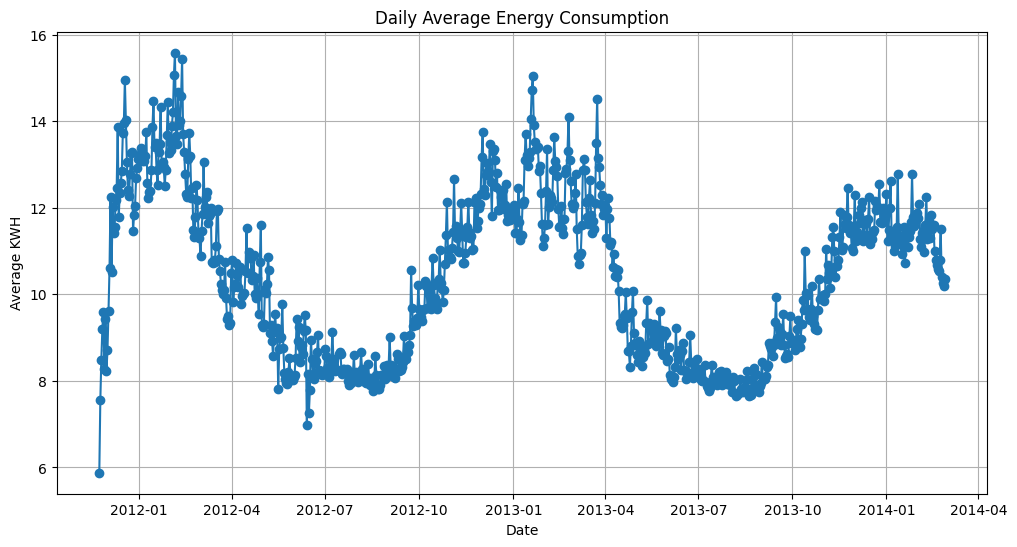

In [ ]:
#plotting the data
plt.figure(figsize=(12, 6))
plt.plot(DATA['Date'], DATA['Average KWH'], marker='o', linestyle='-')
plt.title('Daily Average Energy Consumption')
plt.xlabel('Date')
plt.ylabel('Average KWH')
plt.grid(True)
plt.show()

only one value is considered outlier hence removed.

In [ ]:
DATA.head()


,Average KWH,weather_cluster,Date
0,5.878750,1,2011-11-23
1,7.555042,3,2011-11-24
2,8.494609,3,2011-11-25
3,9.207879,3,2011-11-26
4,9.592493,3,2011-11-27


#**SARIMAX MODEL**

In [ ]:
merged_df.head(2)

,Date,Average KWH,time,weather_code (wmo code),temperature_2m_max (°C),temperature_2m_min (°C),temperature_2m_mean_C,apparent_temperature_max (°C),apparent_temperature_min (°C),apparent_temperature_mean (°C),sunrise (iso8601),sunset (iso8601),daylight_duration (s),sunshine_duration (s),precipitation_sum (mm),rain_sum (mm),precipitation_hours (h),wind_speed_10m_max (km/h),wind_direction_10m_dominant (°),weather_cluster
0,2011-11-23,5.878750,23/11/2011,3,10.2,2.9,7.4,7.5,0.1,4.9,2011-11-23T08:31,2011-11-23T17:02,30669.77,20276.44,0.0,0.0,0,13.9,238,1
1,2011-11-24,7.555042,24/11/2011,3,12.1,7.7,9.6,9.2,5.0,6.5,2011-11-24T08:33,2011-11-24T17:01,30511.93,8172.79,0.0,0.0,0,24.5,210,3


In [ ]:
# Access the 'weather_cluster' column
weather_cluster_column = merged_df['weather_cluster']

print(weather_cluster_column)

0      1
1      3
2      3
3      3
4      3
      ..
824    3
825    1
826    1
827    1
828    4
Name: weather_cluster, Length: 829, dtype: int32


**Splitting data into test and train sets**

In [ ]:
model_data = merged_df[['Average KWH', 'weather_cluster', 'Date']]


# Compute the index for a 80-20 split
split_index = int(len(model_data) * 0.8)

# Split the data into train and test sets
train_data = model_data.iloc[:split_index]
test_data = model_data.iloc[split_index:]

In [ ]:
train_data.tail()

,Average KWH,weather_cluster,Date
657,8.739282,0,2013-09-10
658,8.870305,0,2013-09-11
659,8.582943,0,2013-09-12
660,8.840700,0,2013-09-13
661,9.355853,3,2013-09-14


In [ ]:
test_data.tail()

,Average KWH,weather_cluster,Date
823,11.513483,3,2014-02-23
824,10.408146,3,2014-02-24
825,10.266493,1,2014-02-25
826,10.193198,1,2014-02-26
827,10.363887,1,2014-02-27


In [ ]:
train_data.set_index('Date', inplace=True)
test_data.set_index('Date', inplace=True)


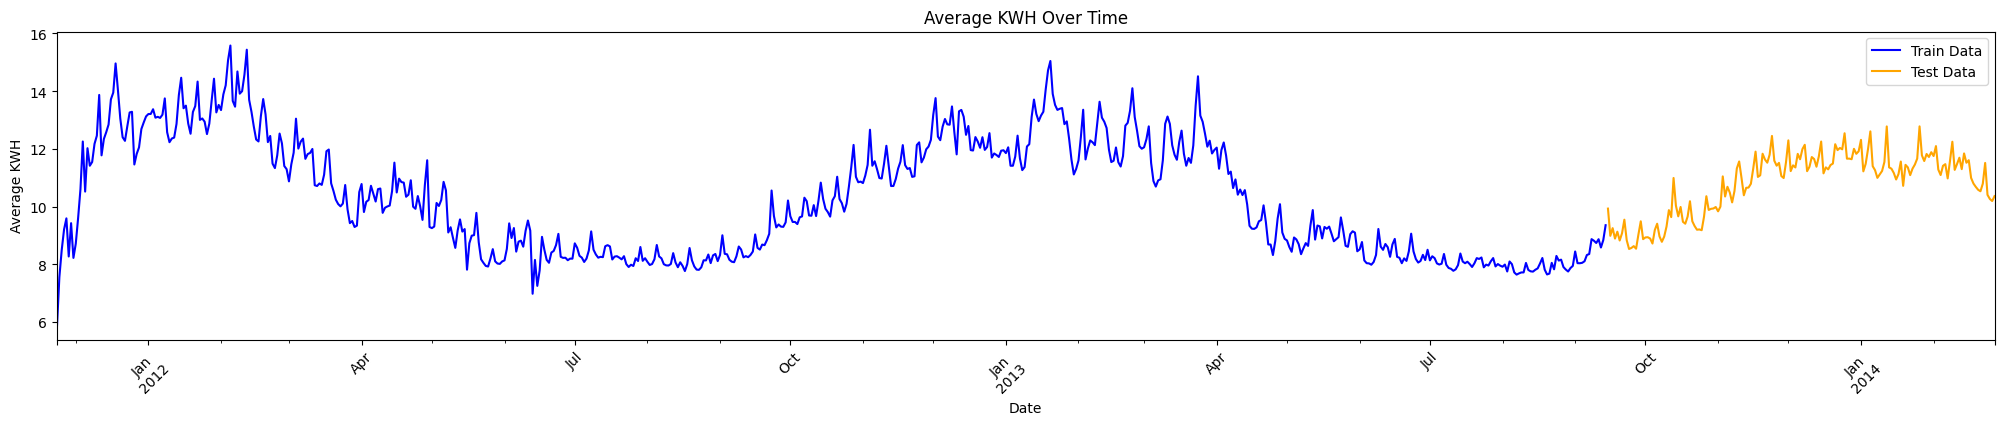

In [ ]:
# Plotting train data
train_data['Average KWH'].plot(figsize=(25, 4), color='blue', label='Train Data')

# Plotting test data on the same plot
test_data['Average KWH'].plot(figsize=(25, 4), color='orange', label='Test Data')

# Add title, labels, and legend
plt.title('Average KWH Over Time')
plt.xlabel('Date')
plt.ylabel('Average KWH')
plt.xticks(rotation=45)  # Rotate date labels for better readability
plt.legend()

# Display the plot
plt.show()


#Plotting ACF PACF for non-seasonal parameters of SARIMAX (p, q)



#**For 'q' we plot ACF**


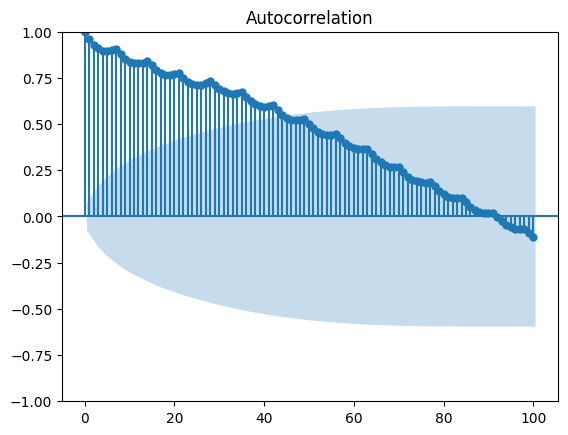

In [ ]:
plot_acf(train_data['Average KWH'],lags=100)
plt.show()

#As the ACF is slowly decaying and there is no clear cutoff, this means 'q' is low so we take q=0

#**For 'p' we plot PACF**

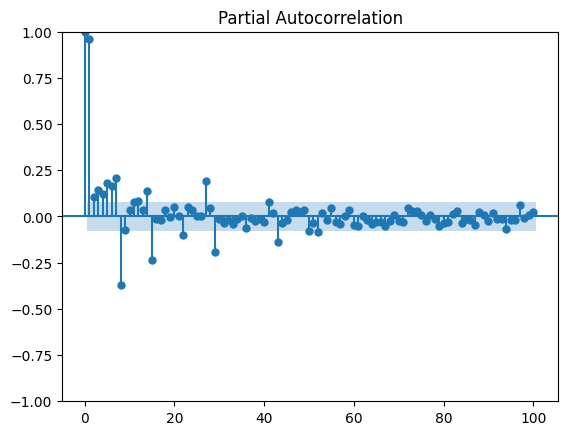

In [ ]:
plot_pacf(train_data['Average KWH'],lags=100)
plt.show()

#As PACF shows that there is a sudden decay after second lag so p=2. The reason we generally focus on the initial significant lags (1, 2, etc.) is that the AR term in ARIMA or SARIMAX is meant to capture the immediate, direct autocorrelation in the time series. Higher-order lags can sometimes represent noise or effects that are better captured by other components of the model (like the seasonal component in SARIMAX).

#For differencing Parameter 'd' we take ADF test for stationarity and apply differencing to make it stationary if it is not stationary. Number of time we differenced to make it stationary gives value for 'd'.

**H0: Data is not stationary.**

**H1: Data is stationary.**

To test this hypothesis we use Augmented Dickey Fuller(ADF) test

In [70]:

ADF = sm.tsa.adfuller(train_data['Average KWH'], autolag='AIC')
pd.Series(ADF[0:4], index=['Test Statistic','p-value','Lags Used','Number of Observations Used'])

,0
Test Statistic,-1.743809
p-value,0.408694
Lags Used,14.000000
Number of Observations Used,647.000000


**Interpretation:**
As p-value is greater than 0.05 also test statistics is not very negative, so we fail to reject the  null hypothesis and conclude that data is non-stationary.

#To make it stationary we use differencing.

In [71]:
# function for differencing
def difference(dataset, interval):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset.iloc[i] - dataset.iloc[i - interval]
        diff.append(value)
    return diff

In [72]:
ADF  = sm.tsa.adfuller(difference(train_data['Average KWH'],1), autolag='AIC')
pd.Series(ADF[0:4], index=['Test Statistic','p-value','Lags','No. of observations used'])

,0
Test Statistic,-6.002353e+00
p-value,1.645892e-07
Lags,2.000000e+01
No. of observations used,6.400000e+02


Now, p-value is less than 0.05 so we reject null hypothesis and conclude that after differencing data is stationary. So, **d=1** as it became stationary after first differencing.


#**So non-seasonal parameters are (p, d, q) = (1, 1, 0)**

**Now for seasonal parameters (P, D, Q) we use grid search.**

#**GRID SEARCH**

In [ ]:
import itertools
import warnings
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Define the P, D, Q parameters
p = d = q = range(0, 7)
P = D = Q = range(0, 7)

s = [14]  # Seasonality period at s=14 means seasonality to be captured biweekly or fortnightly for daily data

# Generate all different combinations of p, d, q triplets
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], s[0]) for x in list(itertools.product(P, D, Q))]

best_aic = float('inf')
best_param = None
best_seasonal_param = None

warnings.filterwarnings("ignore")  # specify to ignore warning messages

for param in pdq:
    for seasonal_param in seasonal_pdq:
        try:
            mod = SARIMAX(train_data['Average KWH'],
                          order=param,
                          seasonal_order=seasonal_param,
                          enforce_stationarity=False,
                          enforce_invertibility=False)

            results = mod.fit()

            if results.aic < best_aic:
                best_aic = results.aic
                best_param = param
                best_seasonal_param = seasonal_param

        except:
            continue

print(f'Best SARIMA parameters: {best_param} x {best_seasonal_param} with AIC: {best_aic}')

# Fit the best model
best_model = SARIMAX(train_data['Average KWH'],
                     order=best_param,
                     seasonal_order=best_seasonal_param,
                     enforce_stationarity=False,
                     enforce_invertibility=False)

best_model_fit = best_model.fit()



As this code keeps crashing so we choose seasonal-parameters manually. In this case we choose

 **(p, d, q) = (7, 1, 1) and (P, D, Q, s) = (1, 1, 0, 14)**

**Fitting SARIMA model.**

In [73]:
train_data.head(2)

,Average KWH,weather_cluster,log_Average KWH
Date,,,
2011-11-23,5.878750,0,1.771344
2011-11-24,7.555042,4,2.022215


In [75]:
## Defining target and independent variables(endogeneous and exogenous variables)
endog = train_data['Average KWH']
exog = train_data[['weather_cluster']]
# Adding a constant to the exogenous variables to help model include intercept
exog = sm.add_constant(exog)
# Creating the SARIMAX(5, 1, 0) (1, 1, 0,30) model with the exogenous data
mod = sm.tsa.statespace.SARIMAX(endog=endog, exog=exog, order=(5, 1, 0), seasonal_order=(1, 1, 0, 30))
# Fitting the model
model_fit = mod.fit()
# Model summary
print(model_fit.summary())

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


                                     SARIMAX Results                                      
Dep. Variable:                        Average KWH   No. Observations:                  662
Model:             SARIMAX(5, 1, 0)x(1, 1, 0, 30)   Log Likelihood                -587.275
Date:                            Sun, 25 Aug 2024   AIC                           1192.551
Time:                                    18:13:23   BIC                           1232.576
Sample:                                11-23-2011   HQIC                          1208.096
                                     - 09-14-2013                                         
Covariance Type:                              opg                                         
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
const            1.144e-08   8.44e+04   1.36e-13      1.000   -1.65e+05    1.65e+05
weather_cluster     

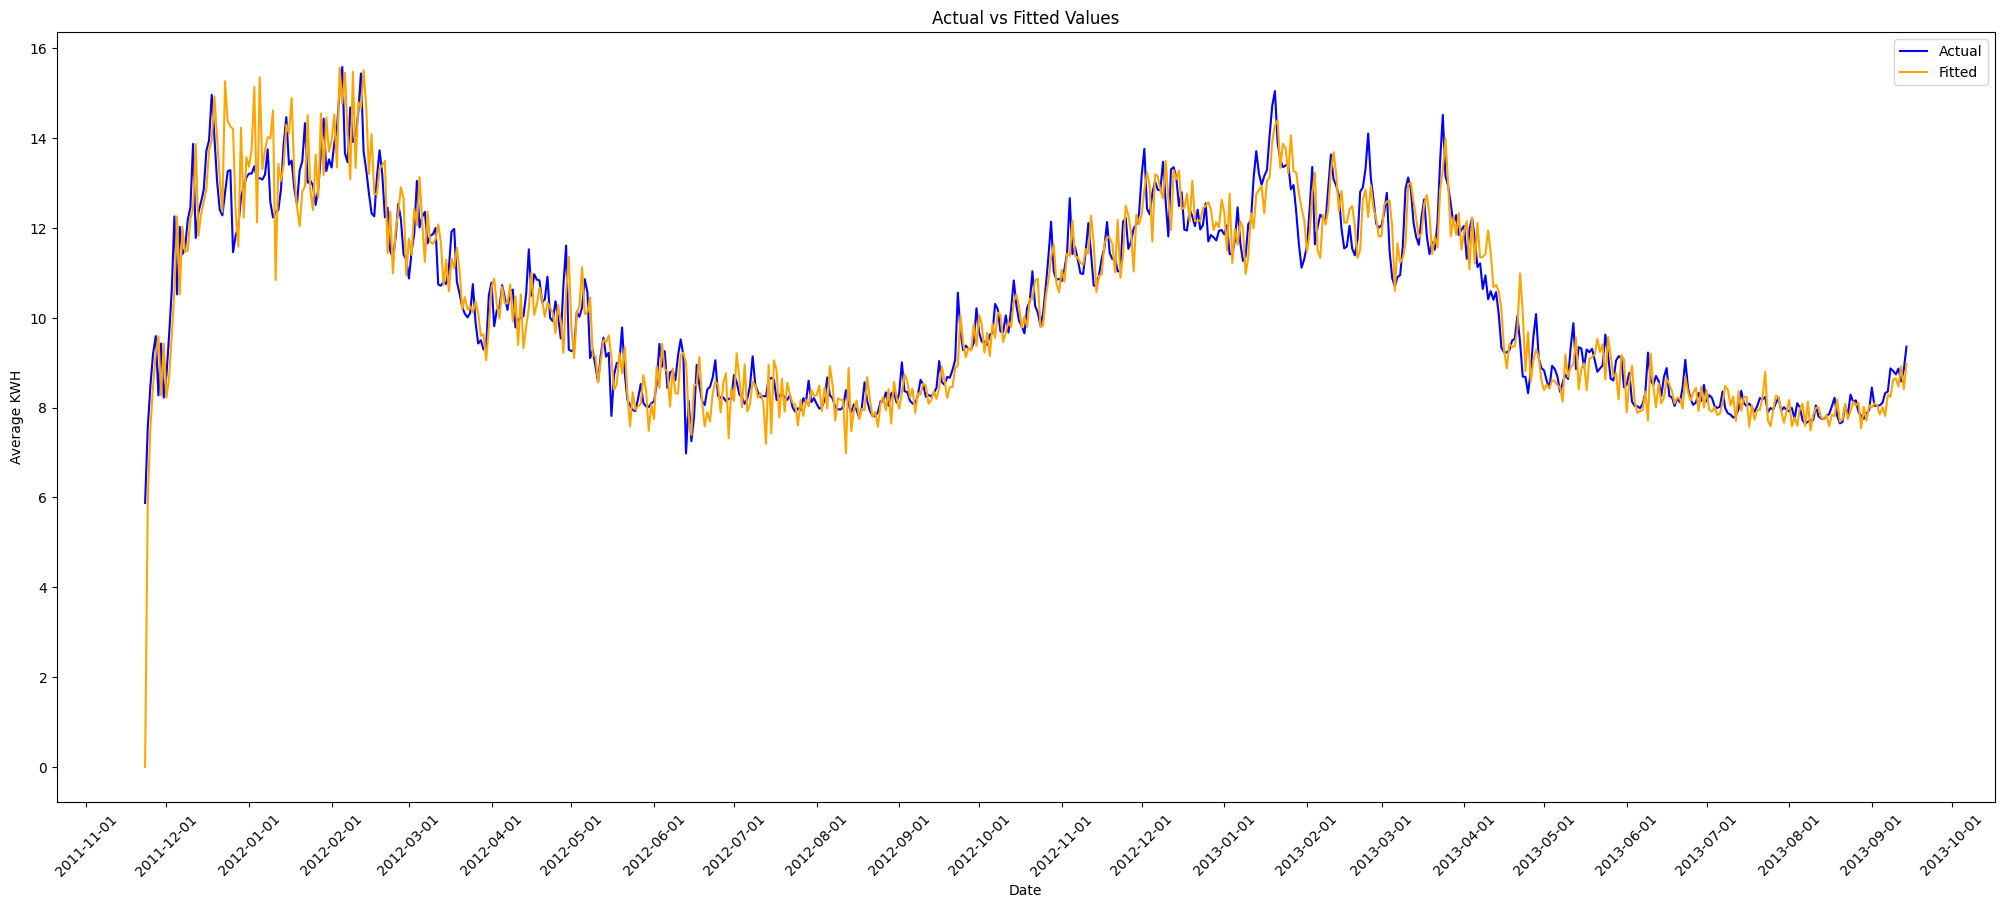

In [76]:
# Plotting the Actual Average KWH values from the train_data and fitted SARIMAX values
plt.figure(figsize=(25, 10))
plt.plot(train_data.index, train_data['Average KWH'], label='Actual', color='blue')
plt.plot(train_data.index, model_fit.fittedvalues, label='Fitted', color='orange')

# Set the x-axis to display dates properly
plt.gca().xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%Y-%m-%d'))  # date format on x-axis
plt.gca().xaxis.set_major_locator(plt.matplotlib.dates.MonthLocator())  # Setting monthwise x-axis
plt.xticks(rotation=45)  # Rotating date labels to better read dates

# title and labels
plt.title('Actual vs Fitted Values')
plt.xlabel('Date')
plt.ylabel('Average KWH')

plt.legend()
plt.show()

**Making Predictions**

In [77]:
predict = model_fit.predict(start = len(train_data),end = len(train_data)+len(test_data)-1,exog = sm.add_constant(test_data[['weather_cluster']]))
test_data['SARIMAXpredicted'] = predict.values
test_data.head(100)




<ipython-input-77-7af745f30eed>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['SARIMAXpredicted'] = predict.values


,Average KWH,weather_cluster,SARIMAXpredicted,ARIMAXprediction,log_Average KWH,log_ARIMAXprediction
Date,,,,,,
2013-09-15,9.931283,1,9.306394,9.232732,2.295690,2.220687
2013-09-16,8.986707,4,9.257602,9.115505,2.195747,2.209868
2013-09-17,9.254242,4,9.197964,9.063848,2.225082,2.204362
2013-09-18,8.892137,4,8.869944,9.070019,2.185167,2.204869
2013-09-19,9.131291,1,8.835352,9.068496,2.211707,2.203546
...,...,...,...,...,...,...
2013-12-19,11.441902,0,10.866417,9.445426,2.437282,2.233321
2013-12-20,11.490752,0,11.196442,9.448119,2.441543,2.233530
2013-12-21,12.162805,4,11.003735,9.460971,2.498383,2.236169


In [78]:
# Calculating evaluation metrics RMSE, MAE and MAPE
MAE = mean_absolute_error(test_data['Average KWH'], test_data['SARIMAXpredicted'])
MAPE = mean_absolute_percentage_error(test_data['Average KWH'], test_data['SARIMAXpredicted']) * 100
RMSE = mean_squared_error(test_data['Average KWH'], test_data['SARIMAXpredicted'], squared=False)
print(f"MAE: {MAE:.4f}, MAPE: {MAPE:.2f}%")
print(f'RMSE: {RMSE: .4f}')


MAE: 0.7008, MAPE: 6.35%
RMSE:  0.8775


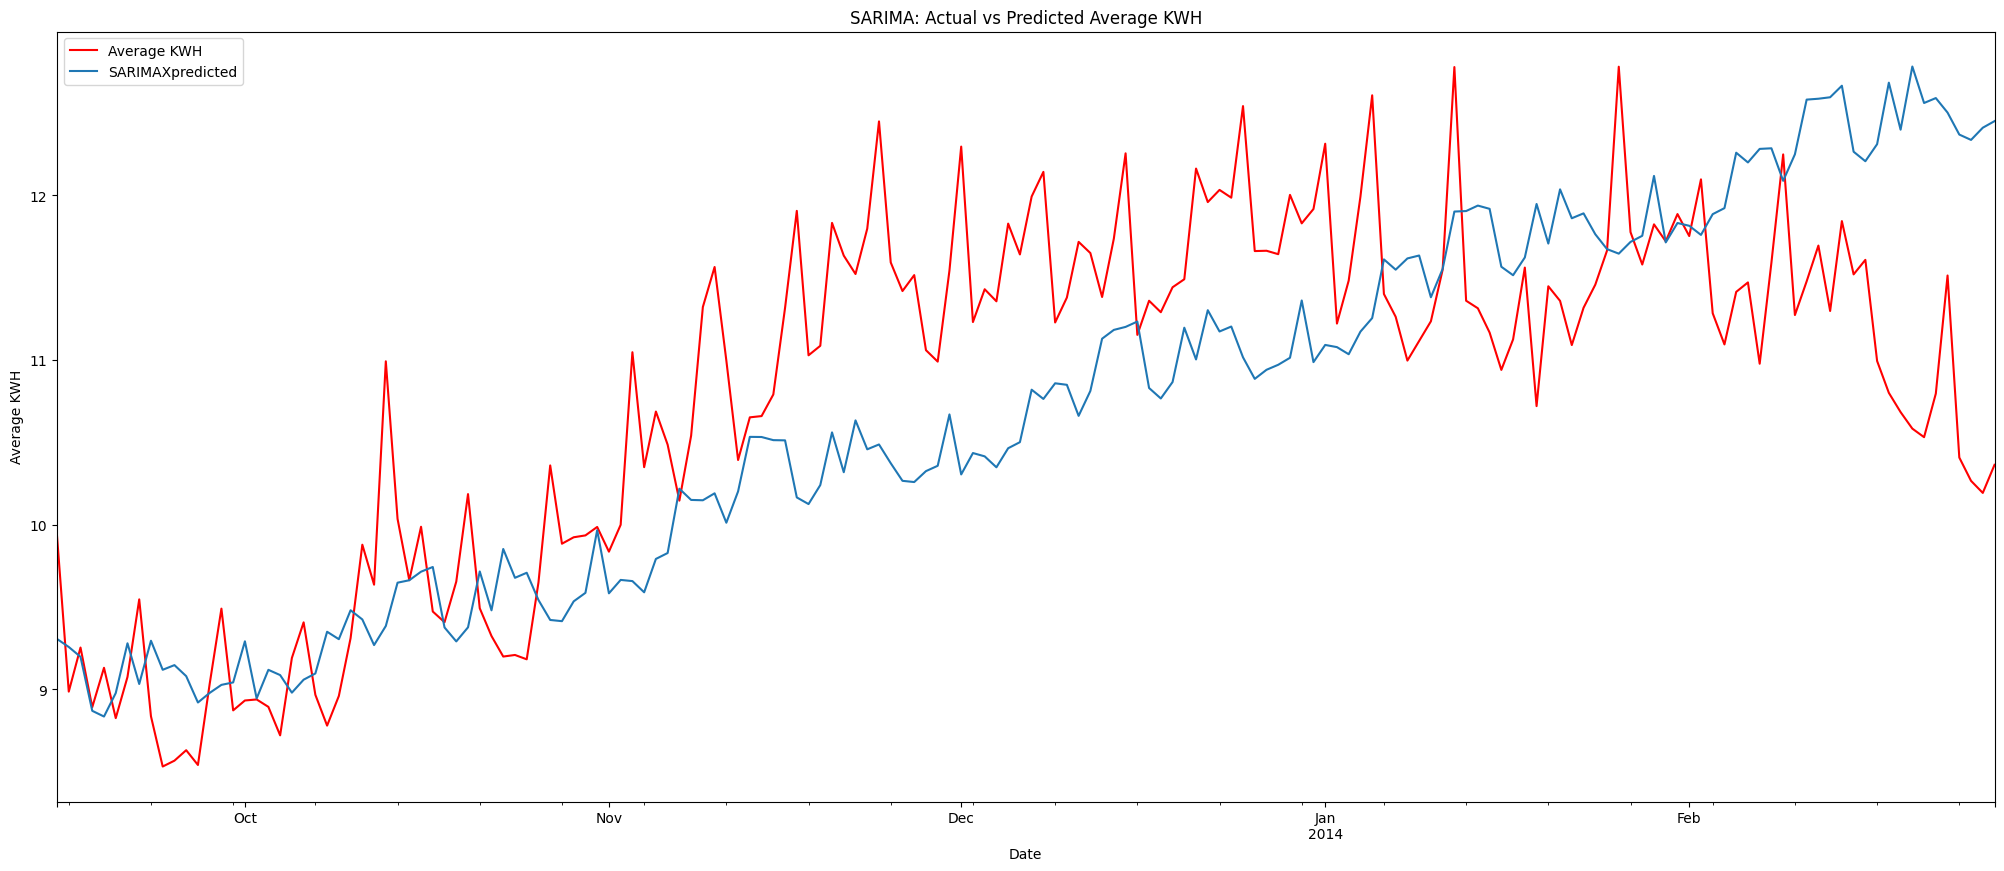

In [79]:
#plotting actual vs predicted values
test_data['Average KWH'].plot(figsize=(25,10),color = 'red')
test_data['SARIMAXpredicted'].plot()
# Adding a legend to mention color used to plot actual and predicted values
plt.legend()
plt.title('SARIMA: Actual vs Predicted Average KWH')
plt.xlabel('Date')
plt.ylabel('Average KWH')
plt.show()


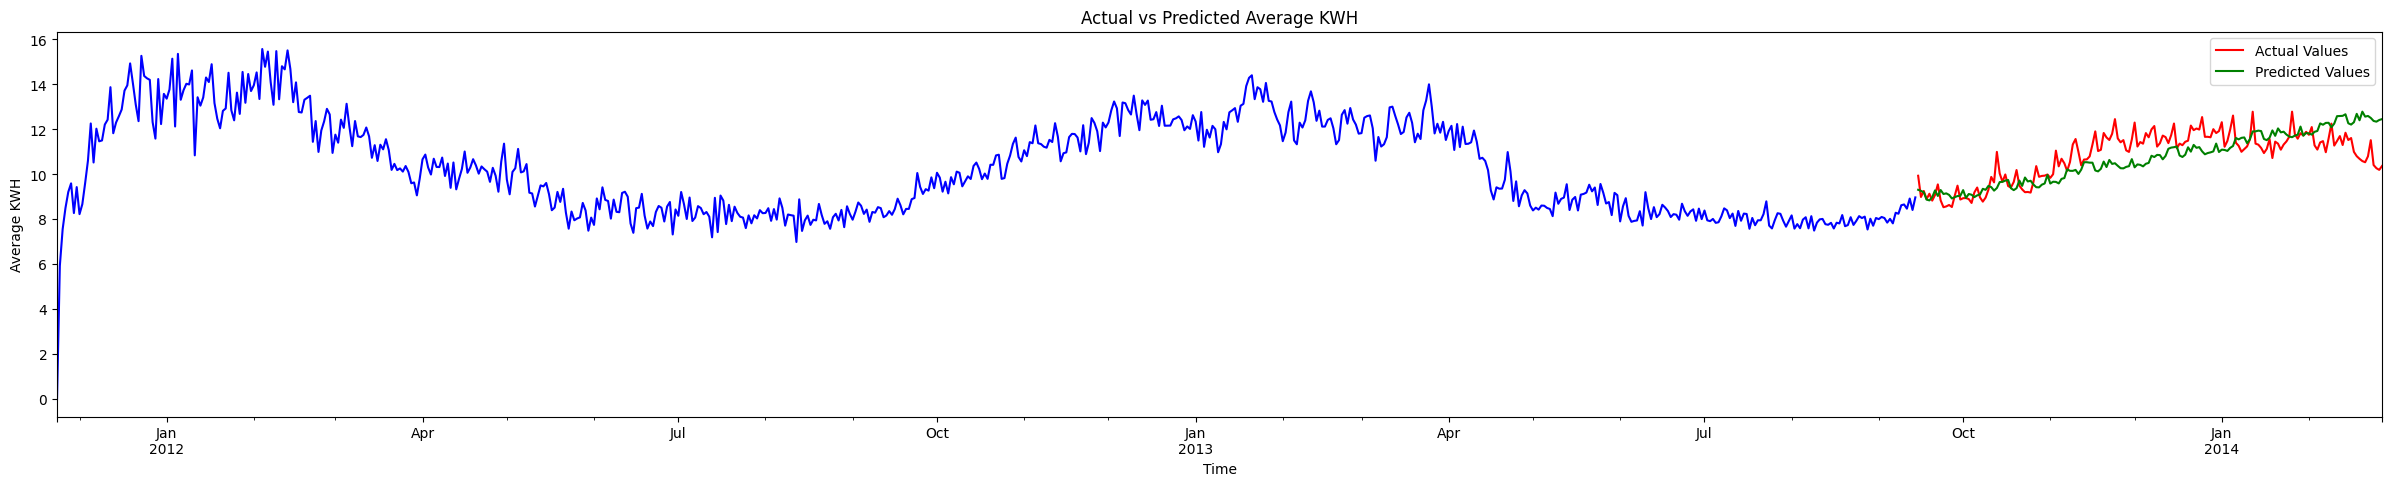

In [81]:
#Plotting fitted SARIMAX values, actual test values and predicted SARIMAX test values
model_fit.fittedvalues.plot(figsize=(30, 5), color='blue')
test_data['Average KWH'].plot(color='red', label='Actual Values')
test_data['SARIMAXpredicted'].plot(color='green', linestyle='-', label='Predicted Values')
plt.title('Actual vs Predicted Average KWH')
plt.xlabel('Time')
plt.ylabel('Average KWH')

# use legend to define actual, fitted, and predicted values
plt.legend()
plt.show()


#**ARIMAX**

In [82]:
merged_df.head(2)

,Date,Average KWH,time,weather_code (wmo code),temperature_2m_max (°C),temperature_2m_min (°C),temperature_2m_mean_C,apparent_temperature_max (°C),apparent_temperature_min (°C),apparent_temperature_mean (°C),sunrise (iso8601),sunset (iso8601),daylight_duration (s),sunshine_duration (s),precipitation_sum (mm),rain_sum (mm),precipitation_hours (h),wind_speed_10m_max (km/h),wind_direction_10m_dominant (°),weather_cluster
0,2011-11-23,5.878750,23/11/2011,3,10.2,2.9,7.4,7.5,0.1,4.9,2011-11-23T08:31,2011-11-23T17:02,30669.77,20276.44,0.0,0.0,0,13.9,238,0
1,2011-11-24,7.555042,24/11/2011,3,12.1,7.7,9.6,9.2,5.0,6.5,2011-11-24T08:33,2011-11-24T17:01,30511.93,8172.79,0.0,0.0,0,24.5,210,4


#**Grid Search for hyperparameters**

In [128]:
import pandas as pd
import itertools
import warnings
from statsmodels.tsa.arima.model import ARIMA

# Suppress warnings
warnings.filterwarnings("ignore")

# Define the p, d, and q ranges
p = range(0, 7)  # AR order
d = range(0, 2)  # Differencing
q = range(0, 7)  # MA order

# Create a list with all combinations of p, d, q
pdq = list(itertools.product(p, d, q))

# Exogenous variable(s)
exog_train = train_data[['weather_cluster']]

# Initialize a DataFrame to store the results
results = []

# Iterate over all combinations
for param in pdq:
    try:
        # Fit ARIMAX model
        model = ARIMA(train_data['Average KWH'], order=param, exog=exog_train)
        model_fit = model.fit()

        # Save the results
        results.append((param, model_fit.aic))
    except:
        continue

# Create a DataFrame from the results
result_df = pd.DataFrame(results, columns=['(p,d,q)', 'AIC'])

# Find the best combination (lowest AIC)
best_param = result_df.loc[result_df['AIC'].idxmin()]

print(f"Best ARIMAX Model: {best_param['(p,d,q)']} with AIC = {best_param['AIC']:.2f}")


Best ARIMAX Model: (6, 1, 6) with AIC = 740.79


In [129]:
# defining weather clusters for training and test data as exogenous variables
exog_train = train_data[['weather_cluster']]
exog_test = test_data[['weather_cluster']]

# Fitting the ARIMAX(1, 0, 3) model
modelARX = ARIMA(train_data['Average KWH'], order=(6, 1, 6), exog=exog_train)
modelARX_fit = modelARX.fit()

#model summary
print(modelARX_fit.summary())

                               SARIMAX Results                                
Dep. Variable:            Average KWH   No. Observations:                  662
Model:                 ARIMA(6, 1, 6)   Log Likelihood                -356.394
Date:                Sun, 25 Aug 2024   AIC                            740.788
Time:                        21:16:41   BIC                            803.701
Sample:                    11-23-2011   HQIC                           765.172
                         - 09-14-2013                                         
Covariance Type:                  opg                                         
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
weather_cluster    -0.0070      0.008     -0.890      0.373      -0.023       0.008
ar.L1              -0.9726      0.010    -96.321      0.000      -0.992      -0.953
ar.L2              -0.9872      

In [131]:
# Predicting the test data using ARIMAX model
predictions = modelARX_fit.predict(start=len(train_data),
                                end=len(train_data) + len(test_data) - 1,
                                exog=exog_test)

# Add the predictions to the test_data DataFrame
test_data['ARIMAXprediction'] = predictions



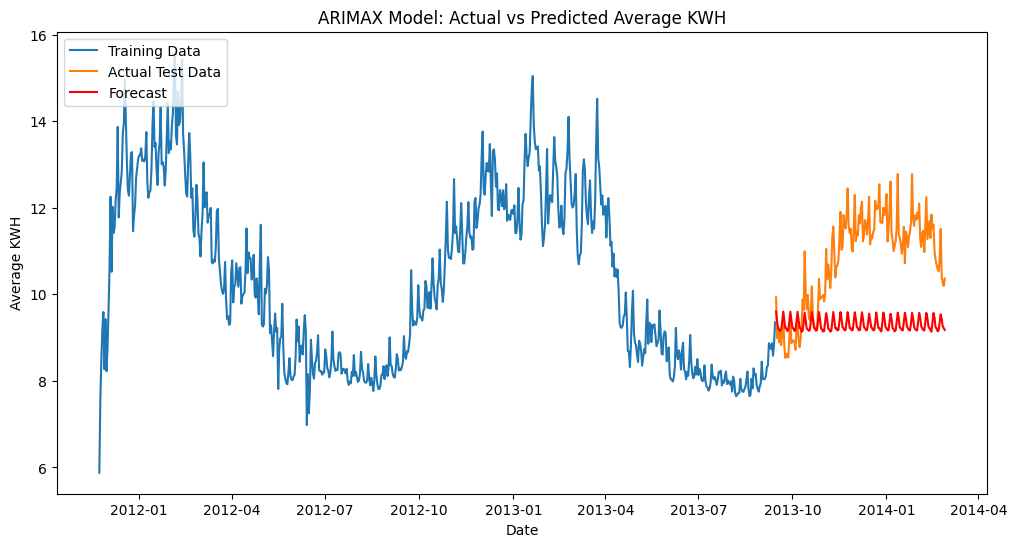

Mean Absolute Error (MAE): 1.604522043237198
Root Mean Squared Error (RMSE): 1.8380214618134583
Mean Absolute Percentage Error (MAPE): 994.18%


In [132]:
# Plot
plt.figure(figsize=(12, 6))
plt.plot(train_data['Average KWH'], label='Training Data')
plt.plot(test_data['Average KWH'], label='Actual Test Data')
plt.plot(test_data['ARIMAXprediction'], label='Forecast', color='red')
plt.legend(loc='upper left')
plt.xlabel('Date')
plt.ylabel('Average KWH')
plt.title('ARIMAX Model: Actual vs Predicted Average KWH')
plt.show()

# Calculating Evaluation metrics MAE, RMSE, MAPE
mae = mean_absolute_error(test_data['Average KWH'], test_data['ARIMAXprediction'])
rmse = mean_squared_error(test_data['Average KWH'], test_data['ARIMAXprediction'], squared=False)
mape = np.mean(np.abs((test_data['Average KWH'] - test_data['ARIMAXprediction'] / test_data['Average KWH']))) * 100

print(f'Mean Absolute Error (MAE): {mae}')
print(f'Root Mean Squared Error (RMSE): {rmse}')
print(f'Mean Absolute Percentage Error (MAPE): {mape:.2f}%')

**Applying log-transformation to data.**

In [133]:
# Log transform using .loc to avoid SettingWithCopyWarning
train_data.loc[:, 'log_Average KWH'] = np.log(train_data['Average KWH'])
test_data.loc[:, 'log_Average KWH'] = np.log(test_data['Average KWH'])

In [134]:
# Fit ARIMAX model
ARIMAmodel = ARIMA(train_data['log_Average KWH'], order=(6, 1, 6), exog=exog_train)
ARIMAmodel_fit = ARIMAmodel.fit()
# Predict the test set
predictions1 = ARIMAmodel_fit.predict(start=len(train_data),
                                end=len(train_data) + len(test_data) - 1,
                                exog=exog_test)

# Add the predictions to the test_data DataFrame
test_data['log_ARIMAXprediction'] = predictions1




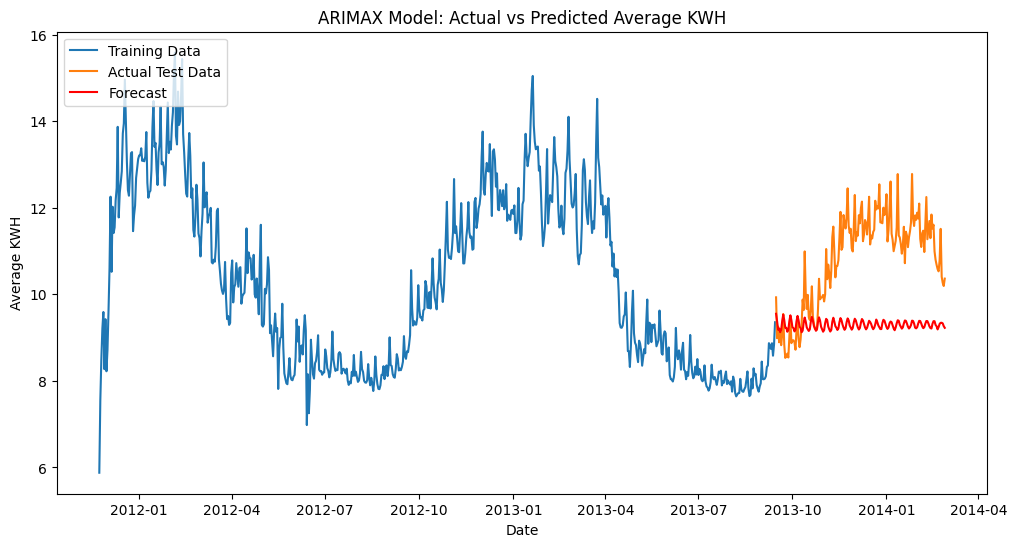

Mean Absolute Error (MAE): 1.6137654194357827
Root Mean Squared Error (RMSE): 1.8522424262231814
Mean Absolute Percentage Error (MAPE): 14.23%


In [135]:
# Forecast
n_periods = len(test_data)
forecast_log =ARIMAmodel_fit.forecast(steps=n_periods, exog = exog_test)

# Back-transform
forecast = np.exp(forecast_log)
forecast_series = pd.Series(forecast, index=test_data.index)

# Plot
plt.figure(figsize=(12, 6))
plt.plot(train_data['Average KWH'], label='Training Data')
plt.plot(test_data['Average KWH'], label='Actual Test Data')
plt.plot(forecast_series, label='Forecast', color='red')
plt.legend(loc='upper left')
plt.xlabel('Date')
plt.ylabel('Average KWH')
plt.title('ARIMAX Model: Actual vs Predicted Average KWH')
plt.show()

# Calculate MAE, RMSE, MAPE
mae = mean_absolute_error(test_data['Average KWH'], forecast_series)
rmse = mean_squared_error(test_data['Average KWH'], forecast_series, squared=False)
mape = np.mean(np.abs((test_data['Average KWH'] - forecast_series) / test_data['Average KWH'])) * 100

print(f'Mean Absolute Error (MAE): {mae}')
print(f'Root Mean Squared Error (RMSE): {rmse}')
print(f'Mean Absolute Percentage Error (MAPE): {mape:.2f}%')

#**GRU (Gated Recurrent Unit) Model**

In [87]:
# using MinMaxScaler for normaliz
KWH_scaling = MinMaxScaler()
weather_scaling = MinMaxScaler()

scaled_KWH = KWH_scaling.fit_transform(filtered_data[['Average KWH']])
scaled_weather_clusters = weather_scaling.fit_transform(filtered_data[['weather_cluster']])

In [88]:
# Convert the series to sequences including exogenous variables
def create_sequences(data, exog_data, time_steps=1):
    X, y = [], []
    for i in range(len(data) - time_steps):
        x_seq = np.hstack((data[i:(i + time_steps)], exog_data[i:(i + time_steps)]))
        X.append(x_seq)
        y.append(data[i + time_steps, 0])
    return np.array(X), np.array(y)

In [90]:
time_steps = 10  # This value tells how many values from previous data would be used to predict next value.
X, y = create_sequences(scaled_KWH, scaled_weather_clusters, time_steps) # seuence shape = (samples, features, time steps)

In [92]:
# Reshaping X for GRU (samples, time steps, features)
X = X.reshape((X.shape[0], X.shape[1], 2))  # 2 features: Average KWH and weather_cluster

In [93]:
# Splitting the data into train and test datasets using 80-20% split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

#**GRID SEARCH for parameters.**

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Dropout
from tensorflow.keras.optimizers import Adam, RMSprop
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.model_selection import GridSearchCV

# Custom wrapper for Keras models
class KerasRegressor(BaseEstimator, RegressorMixin):
    def __init__(self, units=50, learning_rate=0.001, dropout=0.0, optimizer='adam', epochs=10, batch_size=32):
        self.units = units
        self.learning_rate = learning_rate
        self.dropout = dropout
        self.optimizer = optimizer
        self.epochs = epochs
        self.batch_size = batch_size
        self.model = None

    def build_model(self):
        model = Sequential()
        model.add(GRU(units=self.units, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
        model.add(Dropout(self.dropout))
        model.add(GRU(units=self.units))
        model.add(Dense(1))

        if self.optimizer == 'adam':
            opt = Adam(learning_rate=self.learning_rate)
        else:
            opt = RMSprop(learning_rate=self.learning_rate)

        model.compile(optimizer=opt, loss='mse')
        return model

    def fit(self, X, y):
        self.model = self.build_model()
        self.model.fit(X, y, epochs=self.epochs, batch_size=self.batch_size, verbose=0)
        return self

    def predict(self, X):
        return self.model.predict(X).flatten()

# Now we proceed with the hyperparameter tuning part
# Example hyperparameters to search over
param_grid = {
    'units': [50, 100, 200],
    'batch_size': [16, 32, 64],
    'epochs': [50, 100, 200],
    'learning_rate': [0.001, 0.01],
    'dropout': [0.0, 0.2, 0.5],
    'optimizer': ['adam', 'rmsprop']
}

# Grid search
grid = GridSearchCV(estimator=KerasRegressor(), param_grid=param_grid, cv=3)
grid_result = grid.fit(X_train, y_train)

# Best parameters and score
print(f"Best parameters: {grid_result.best_params_}")
print(f"Best score: {grid_result.best_score_}")



7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 89ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 104ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 108ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 86ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 89ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 83ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 102ms/step
7/7 ━━━━━

Code crashes after running for hours so manually assaigning...

In [94]:
# Define the GRU model
model = Sequential()
model.add(GRU(50, return_sequences=False, input_shape=(X_train.shape[1], X_train.shape[2]))) #adding GRU layer
model.add(Dense(1)) #Adding dense layer

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Summary of the model
model.summary()


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ gru_1 (GRU)                          │ (None, 50)                  │           8,100 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 8,151 (31.84 KB)

 Trainable params: 8,151 (31.84 KB)

 Non-trainable params: 0 (0.00 B)

In [95]:
# Train the model
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test), verbose=1)


Epoch 1/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - loss: 0.2078 - val_loss: 0.0093
Epoch 2/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0212 - val_loss: 0.0057
Epoch 3/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0112 - val_loss: 0.0028
Epoch 4/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0067 - val_loss: 0.0025
Epoch 5/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0052 - val_loss: 0.0030
Epoch 6/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0042 - val_loss: 0.0031
Epoch 7/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0041 - val_loss: 0.0027
Epoch 8/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0038 - val_loss: 0.0025
Epoch 9/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0040 - val_loss: 0.0024
Epoch 10/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0040 - val_loss: 0.0023
Epoch 11/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0037 - val_loss: 0.0024
Epoch 12/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0034 - val_l

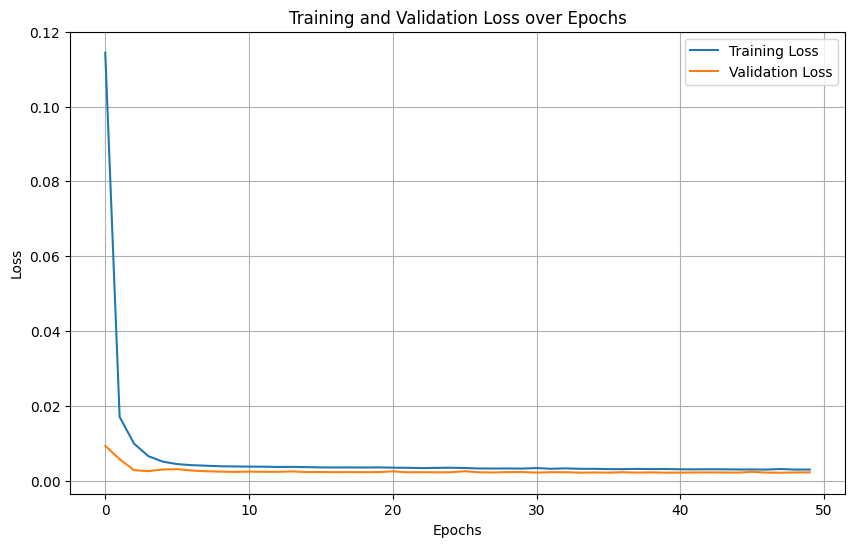

In [96]:
# Training and validation loss from the training
loss = history.history['loss']
val_loss = history.history['val_loss']

# Plotting the losses
plt.figure(figsize=(10, 6))
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss over Epochs')
plt.legend()
plt.grid(True)
plt.show()


Good Fit: The model seems to be a good fit for the data since both training and validation losses are low and close to each other.
No Overfitting: There’s no significant indication of overfitting, as the validation loss does not start increasing while the training loss decreases.
Converged Model: The model has converged well, with the losses stabilizing at a low value relatively quickly.
This suggests that your GRU model is performing well on the data you provided.

21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


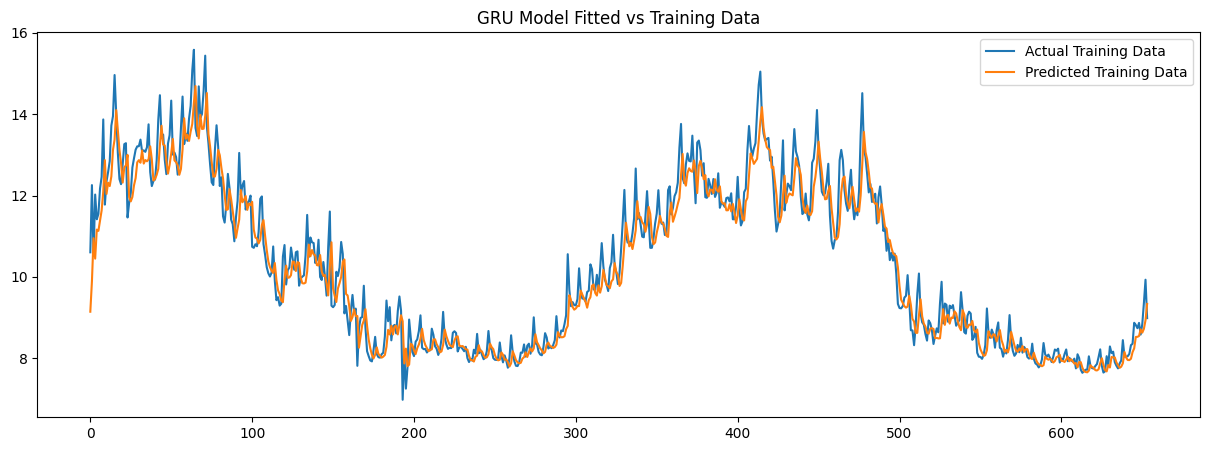

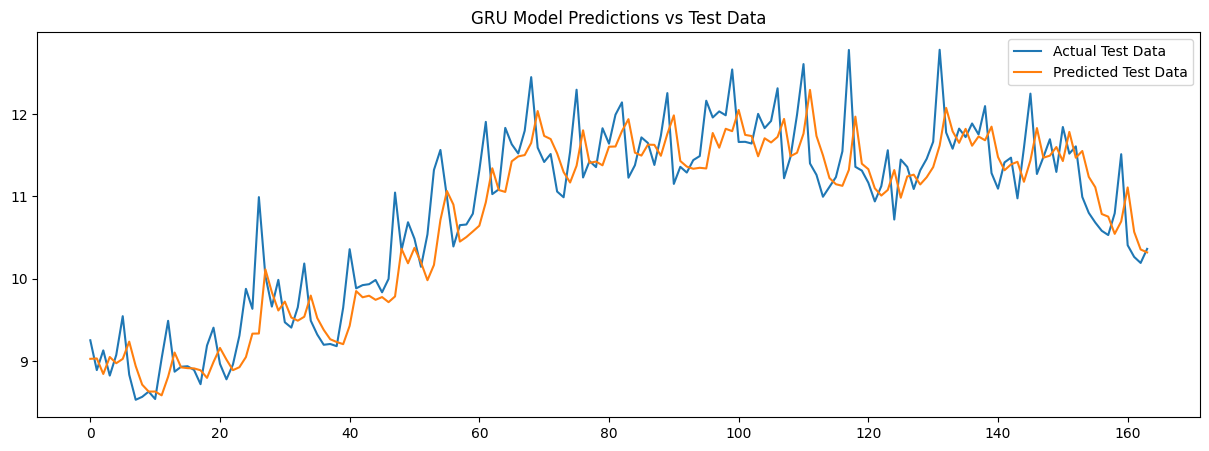

In [97]:
import matplotlib.pyplot as plt

# Make predictions
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

# Invert scaling to get actual values
y_train_pred = KWH_scaling.inverse_transform(y_train_pred)
y_test_pred = KWH_scaling.inverse_transform(y_test_pred)
y_train = KWH_scaling.inverse_transform(y_train.reshape(-1, 1))
y_test = KWH_scaling.inverse_transform(y_test.reshape(-1, 1))

# Plot for training data and predictions
plt.figure(figsize=(15, 5))
plt.plot(y_train, label='Actual Training Data')
plt.plot(y_train_pred, label='Predicted Training Data')
plt.title('GRU Model Fitted vs Training Data')
plt.legend()
plt.show()

# Plot for test data and GRU-predictions
plt.figure(figsize=(15, 5))
plt.plot(y_test, label='Actual Test Data')
plt.plot(y_test_pred, label='Predicted Test Data')
plt.title('GRU Model Predictions vs Test Data')
plt.legend()
plt.show()


In [98]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Calculating evaluation metrics MAE, MAPE, RMSE
mae = mean_absolute_error(y_test, y_test_pred)
mse = mean_squared_error(y_test, y_test_pred)
rmse = np.sqrt(mse)
mape = mean_absolute_percentage_error(y_test, y_test_pred) * 100

print(f'Mean Absolute Error (MAE): {mae}')
print(f'Root Mean Squared Error (RMSE): {rmse}')
print(f'(MAPE): {mape}%')

Mean Absolute Error (MAE): 0.34719925116876804
Root Mean Squared Error (RMSE): 0.457588202964442
(MAPE): 3.153456402555476%


In [99]:
test_data.head()


,Average KWH,weather_cluster,SARIMAXpredicted,ARIMAXprediction,log_Average KWH,log_ARIMAXprediction
Date,,,,,,
2013-09-15,9.931283,1,9.306394,9.232732,2.295690,2.220687
2013-09-16,8.986707,4,9.257602,9.115505,2.195747,2.209868
2013-09-17,9.254242,4,9.197964,9.063848,2.225082,2.204362
2013-09-18,8.892137,4,8.869944,9.070019,2.185167,2.204869
2013-09-19,9.131291,1,8.835352,9.068496,2.211707,2.203546
